<a href="https://colab.research.google.com/github/yfwang09/ShElastic/blob/master/examples/Case04-Sphere_torsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving sphere torsion problem

In this notebook, we test the ShElastic package for solving the stress field induced by torsional traction force on a solid sphere. The problem can be described in the following figure:

<img src="https://raw.githubusercontent.com/yfwang09/ShElastic/master/figures/case04.png" width="200" />

Here the traction boundary is given as:

$$
\mathbf{T}_{\varphi} = S_0\sin(2\theta);\quad\mathbf{T}_{\theta}=\mathbf{T}_{R}=0
$$

Like opening a Gatcha capsule.

In [1]:
# If you run this notebook from colab, run this cell first
import os
codepath = '/content/ShElastic'
if not os.path.exists(codepath):
    !git clone https://github.com/yfwang09/ShElastic.git 
    !pip install pyshtools==4.6.2
os.chdir(os.path.join(codepath, 'examples'))

Cloning into 'ShElastic'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 1211 (delta 66), reused 39 (delta 15), pack-reused 1081
Receiving objects: 100% (1211/1211), 150.63 MiB | 33.21 MiB/s, done.
Resolving deltas: 100% (452/452), done.
     |████████████████████████████████| 10.8MB 197kB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys, os
sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from shelastic.shutil import SHCilmToVector, lmk2K, K2lmk
import time

S0 = 1
a = 1
mu = 1
nu = 1./3

#### traction mode matrix info ####
modepath = '../shelastic/default_modes'
lJmax = 4 # max l degree for saving a single mode
lKmax = 4 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

#### create meshgrid for evaluation ####
Ngrid = 100
theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)

THETA, PHI = np.meshgrid(theta, phi)
Z = np.cos(THETA)
X = np.sin(THETA)*np.cos(PHI)
Y = np.sin(THETA)*np.sin(PHI)
R = np.sqrt(X**2+Y**2+Z**2)
N = np.stack((X/R, Y/R, Z/R), axis=-1)

T_mag = S0*np.sin(2*THETA)
T_usr_mesh = np.zeros(THETA.shape+(3,))
T_usr_mesh[...,0] = T_mag*np.cos(np.pi/2+PHI)
T_usr_mesh[...,1] = T_mag*np.sin(np.pi/2+PHI)

T_usr_vec = np.array([])
for k in range(3):
    T_usr_cilm = pyshtools.expand.SHExpandDHC(T_usr_mesh[...,k].T, sampling=2, lmax_calc=lJmax)
    T_usr_vec = np.hstack((T_usr_vec, SHCilmToVector(T_usr_cilm, lmax = lJmax)))

print(T_usr_vec[np.nonzero(np.abs(T_usr_vec)>1e-8)])
### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from shelastic.shelastic import calSmode
from shelastic.shbv import generate_submat
from shelastic.shvis import visualize_Cmat
import time
ticT = time.time()
shtype = 'reg'
Tmodes = loadmat(os.path.join(modepath, 'Tmodes.mat'))
Cmat = generate_submat(Tmodes, mu, nu, lKmax, lJmax, shtype=shtype)
Umodes = loadmat(os.path.join(modepath, 'Umodes.mat'))
Dmat = generate_submat(Umodes, mu, nu, lKmax, lJmax, shtype=shtype)
Smodes = loadmat(os.path.join(modepath, 'Smodes.mat'))
Smodes = generate_submat(Smodes, mu, nu, lKmax, lJmax, shtype=shtype)
tocT = time.time()
print('Time for loading SH modes: %.4fs'%(tocT-ticT))

[-6.69498607e-17+3.65148372e-01j  7.00098213e-17+3.65148372e-01j
 -3.65148372e-01-6.32304312e-17j  3.65148372e-01-6.47120665e-17j]
Time for loading SH modes: 0.1287s


Then we solve the linear system:

In [3]:
from shelastic.shbv import print_SH_mode
from scipy.sparse.linalg import lsqr
import time

tic = time.time()
A = lsqr(Cmat, T_usr_vec.transpose())
toc = time.time()
print('Residual:', A[3], 'Time:', toc-tic)
A_sol = A[0]
print('Solution:', A_sol.size)
print(T_usr_vec.T-np.dot(Cmat.todense(), A[0]))
index_sol = print_SH_mode(A_sol, m_dir=3)

Residual: 1.166589508035791e-14 Time: 0.001173257827758789
Solution: 75
[[-6.90512406e-20-4.56793662e-50j  1.69463165e-18+5.17618514e-17j
  -9.05988249e-18-1.75715263e-33j -9.54211464e-19+7.08844162e-17j
  -8.74602343e-19-3.11013681e-18j  1.51810794e-16+7.77156117e-16j
  -1.14919280e-18+1.02071071e-33j -1.71489977e-16+8.32667268e-16j
  -8.74602343e-19+3.11013681e-18j  4.79272713e-19+2.00808238e-18j
   4.70938583e-18+6.57116574e-17j -3.10587583e-19+7.41005466e-18j
  -7.79477285e-18+2.73005082e-33j  6.34053423e-19+8.95516794e-18j
   4.70938583e-18-6.57116574e-17j -1.61493240e-18+7.15543813e-18j
  -2.56896134e-18+4.86446919e-18j  2.89038217e-15-1.63076129e-16j
  -4.65395799e-19-3.37885761e-18j  5.98953468e-16+3.10615275e-15j
  -2.18101974e-18+6.39927952e-34j -5.88237652e-16+3.10988560e-15j
  -4.65395799e-19+3.37885761e-18j -2.88448726e-15-1.76705264e-16j
  -2.56896134e-18-4.86446919e-18j  4.89692581e-20-9.82591554e-51j
  -5.98781214e-17-1.71313322e-18j -4.62215511e-17+2.05044298e-33j
   9

And integrate the stress solution:

In [4]:
from shelastic.shbv import fast_stress_solution

X = np.linspace(0.01, np.sqrt(2)/2, 30)
Z = np.linspace(0.01, np.sqrt(2)/2, 30)
Y = np.zeros_like(Z)

R,THETA,PHI = CartCoord_to_SphCoord(X, Y, Z)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(30, 3, 3) 0.03421473503112793


We compare the solution with the analytical solution of the problem:

In [5]:
E3 = 2*S0/3/a
R = np.sqrt(X**2+Y**2+Z**2)
THETA = np.arccos(Z/R)
PHI = np.arctan2(Y, X)

srp = 3*E3*R*np.sin(THETA)*np.cos(THETA)
stp = -3*E3*R*np.sin(THETA)**2
print(X.shape, srp.shape, stp.shape)

(30,) (30,) (30,)


In [6]:
Q = np.zeros(THETA.shape+(3,3))
Q[...,0,0] = np.sin(THETA)*np.cos(PHI)
Q[...,0,1] = np.sin(THETA)*np.sin(PHI)
Q[...,0,2] = np.cos(THETA)
Q[...,1,0] = np.cos(THETA)*np.cos(PHI)
Q[...,1,1] = np.cos(THETA)*np.sin(PHI)
Q[...,1,2] = -np.sin(THETA)
Q[...,2,0] = -np.sin(PHI)
Q[...,2,1] = np.cos(PHI)
Q[...,2,2] = 0
sigma_sph = np.zeros_like(sigma_tot)
for i in np.ndindex(THETA.shape):
    #print(i, sigma_tot[i].shape)
    sigma_sph[i] = np.dot(Q[i], np.dot(sigma_tot[i], Q[i].T))

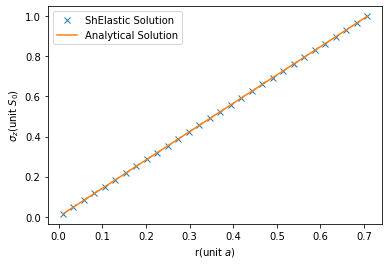

In [7]:
#plt.plot(X.flatten(), np.sqrt(sigma_tot.real[..., 1, 2].flatten()**2 + sigma_tot.real[..., 0, 2].flatten()**2) , 'x')
plt.plot(X.flatten(), sigma_sph.real[...,0, 2], 'x')
plt.plot(X.flatten(), srp)
plt.legend(['ShElastic Solution', 'Analytical Solution'])
plt.xlabel('r(unit $a$)')
plt.ylabel(r'$\sigma_z$(unit $S_0$)')
#plt.savefig('tensile_hole_sz.png')
plt.show()

## Test whether the stress field satisfy the equilibrium condition (force balance) numerically

In [8]:
Ngrid = 100
theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)

THETA, PHI = np.meshgrid(theta, phi)
Z = np.cos(THETA)
X = np.sin(THETA)*np.cos(PHI)
Y = np.sin(THETA)*np.sin(PHI)
R = np.sqrt(X**2+Y**2+Z**2)
N = np.stack((X/R, Y/R, Z/R), axis=-1)

sigma_surf = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)

In [9]:
print(np.linalg.norm(T_usr_mesh-np.sum(sigma_surf.real*N[...,np.newaxis], axis=-2)))

1.5427720602634301e-12


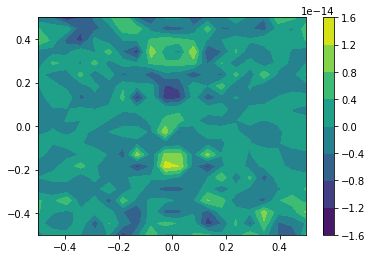

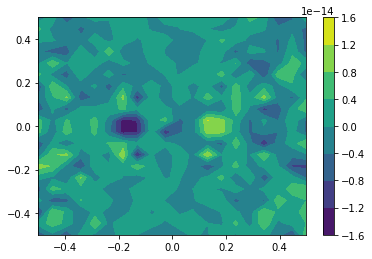

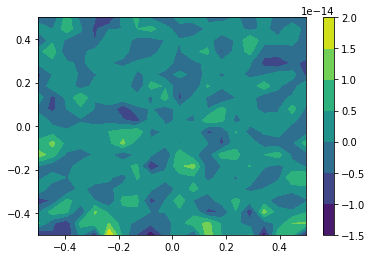

In [10]:
#from SHUtil import CartCoord_to_SphCoord, SphCoord_to_CartCoord, eval_GridC

# The order (Y,X,Z) makes sure that axis 0,1,2 corresponds to X,Y,Z
xgrid = np.linspace(-0.5, 0.5, 20)
Y, X, Z = np.meshgrid(xgrid, xgrid, xgrid)
R, THETA, PHI = CartCoord_to_SphCoord(X, Y, Z)
LAT = 90 - np.rad2deg(THETA)
LON = np.rad2deg(PHI)

MU = 1
NU = 1./3

S_grid = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax, shtype=shtype)

for i in range(3):
    f0 = np.gradient(np.real(S_grid[:,:,:,i,0]), X[:,0,0],Y[0,:,0],Z[0,0,:])[0] +\
         np.gradient(np.real(S_grid[:,:,:,i,1]), X[:,0,0],Y[0,:,0],Z[0,0,:])[1] +\
         np.gradient(np.real(S_grid[:,:,:,i,2]), X[:,0,0],Y[0,:,0],Z[0,0,:])[2]

    plt.figure()
    plt.contourf(X[:,:,0],Y[:,:,0],f0[:,:,0])
    plt.colorbar()
plt.show()

The force is 0 everywhere, which means the equilibrium condition is satisfied.